In [1]:
#!pip3 install numpy scipy sklearn matplotlib pandas statsmodels pmdarima tbats --user --upgrade

In [2]:
import os.path as osp 
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mp
mp.rcParams['figure.figsize'] = [16, 8]

import numpy as np
import pandas as pd
import sklearn as sk
import statsmodels as sm

path = osp.join(osp.curdir,"data_files/mod_met_data.csv")
data = pd.read_csv(path,index_col = 'month')

df = data.copy()
df = df.rename(columns={'Anomaly (deg C)':'anomaly_c', 
                   'Lower confidence limit (2.5%)':'lc', 
                   'Upper confidence limit (97.5%)':'uc'})

BASELINE_TEMP_C = 14.0

df['temp_c_log'] = np.log(df['anomaly_c'].diff(12)+BASELINE_TEMP_C)

df.index = pd.to_datetime(df.index)
df = df[12:]
df.head()

,anomaly_c,lc,uc,temp_c_log
month,,,,
1851-01-01,-0.200739,-0.512604,0.111126,2.672342
1851-02-01,-0.469332,-0.805798,-0.132867,2.629302
1851-03-01,-0.646053,-0.950568,-0.341538,2.635140
1851-04-01,-0.542133,-0.831883,-0.252382,2.642380
1851-05-01,-0.197623,-0.471297,0.076052,2.660998


In [3]:
model_df = df.copy()
model_df = model_df.drop(columns=['lc','uc','temp_c_log'])
model_df

,anomaly_c
month,
1851-01-01,-0.200739
1851-02-01,-0.469332
1851-03-01,-0.646053
1851-04-01,-0.542133
1851-05-01,-0.197623
...,...
2023-02-01,0.872225
2023-03-01,1.124382
2023-04-01,0.927280


/Users/kamal/.local/lib/python3.10/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/Users/kamal/.local/lib/python3.10/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


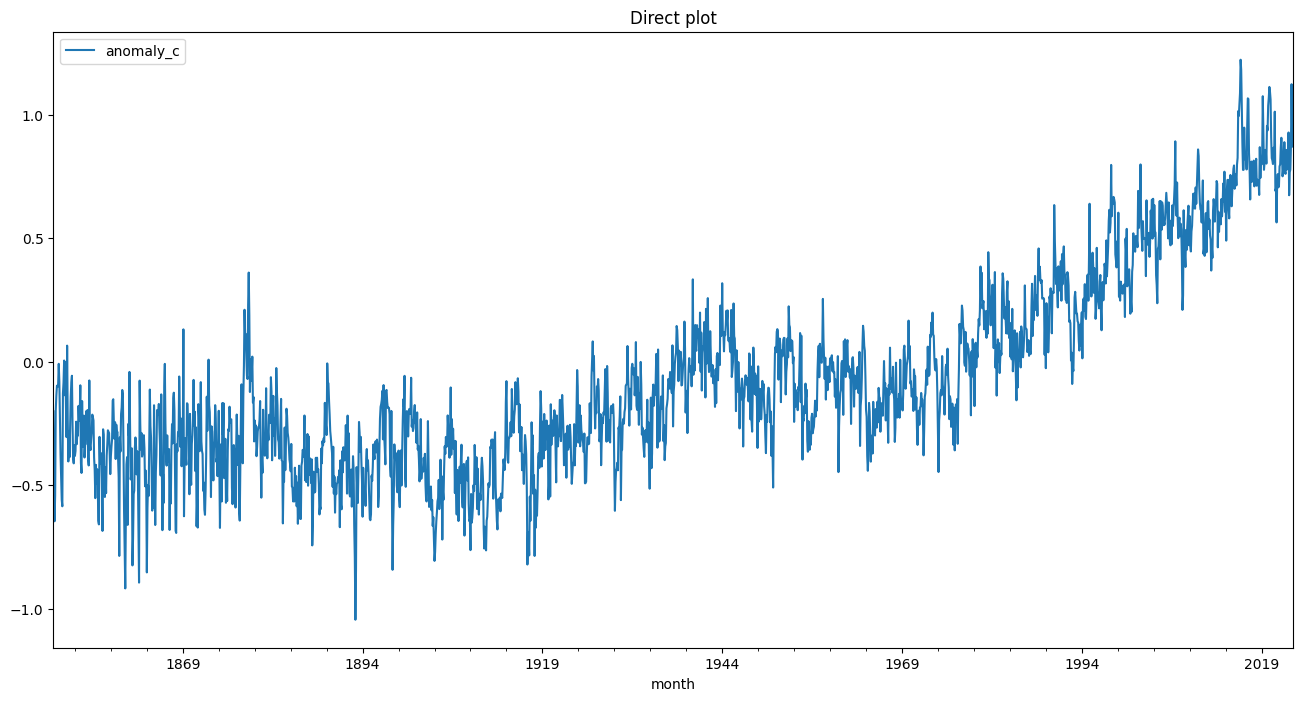

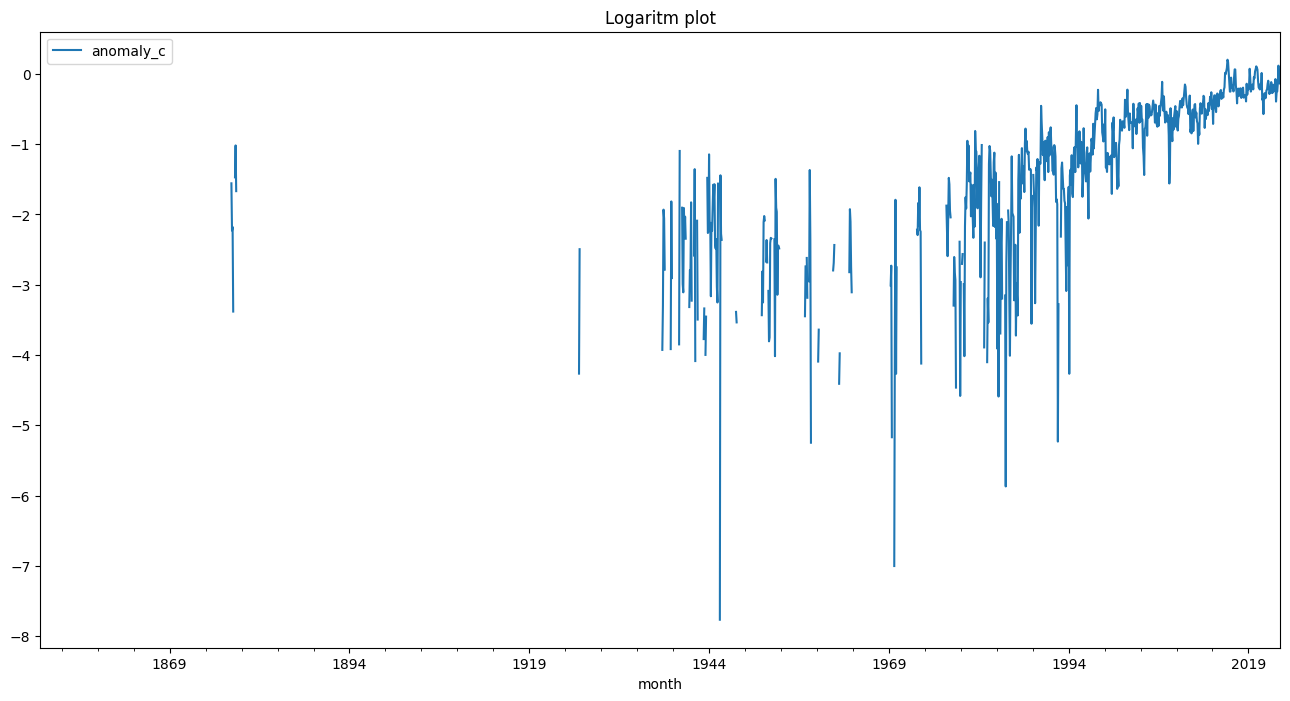

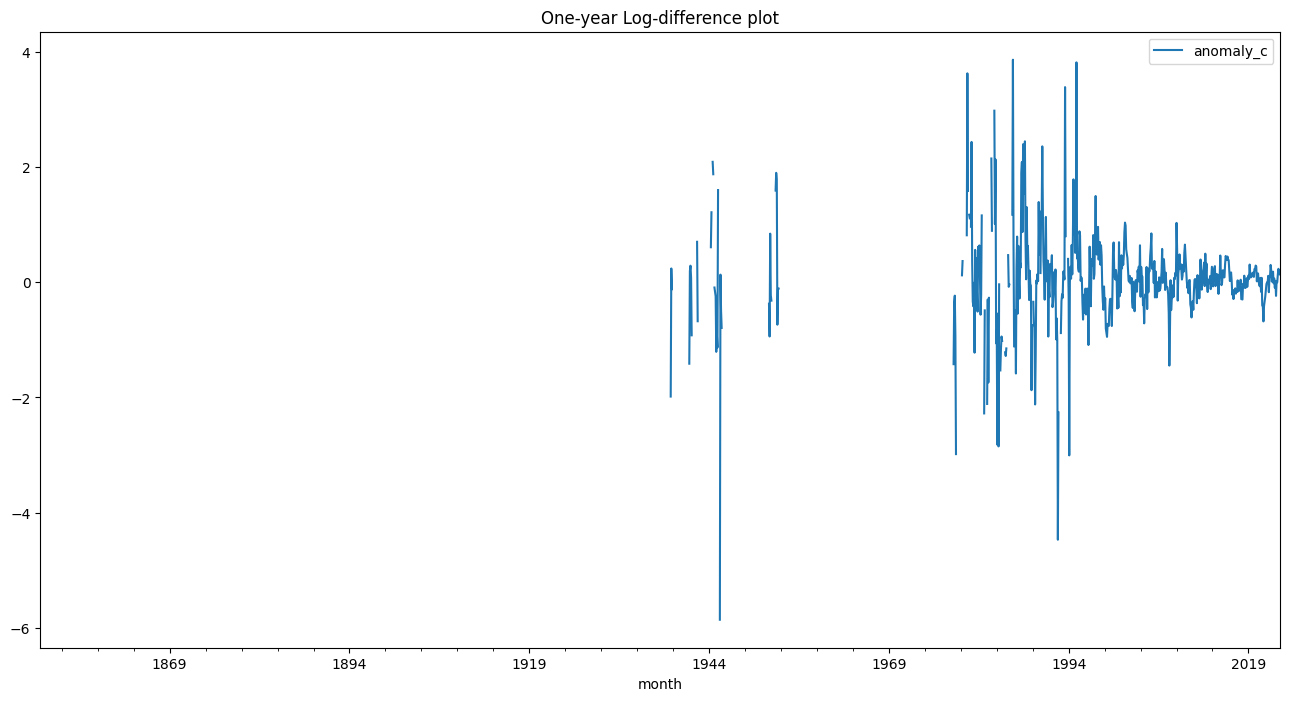

In [4]:
# Plot the data as it is.
model_df.plot(figsize=(16,8))
plt.title("Direct plot")

# Plot the logarithm of data.
#log_data = np.log(model_df)
#log_data.plot(figsize=(16,8))
#plt.title("Logaritm plot")

# Plot the one-year (12 months) difference.
#np.log(model_df).diff(12).plot(figsize=(16,8))
#plt.title("One-year Log-difference plot")

#plt.show()

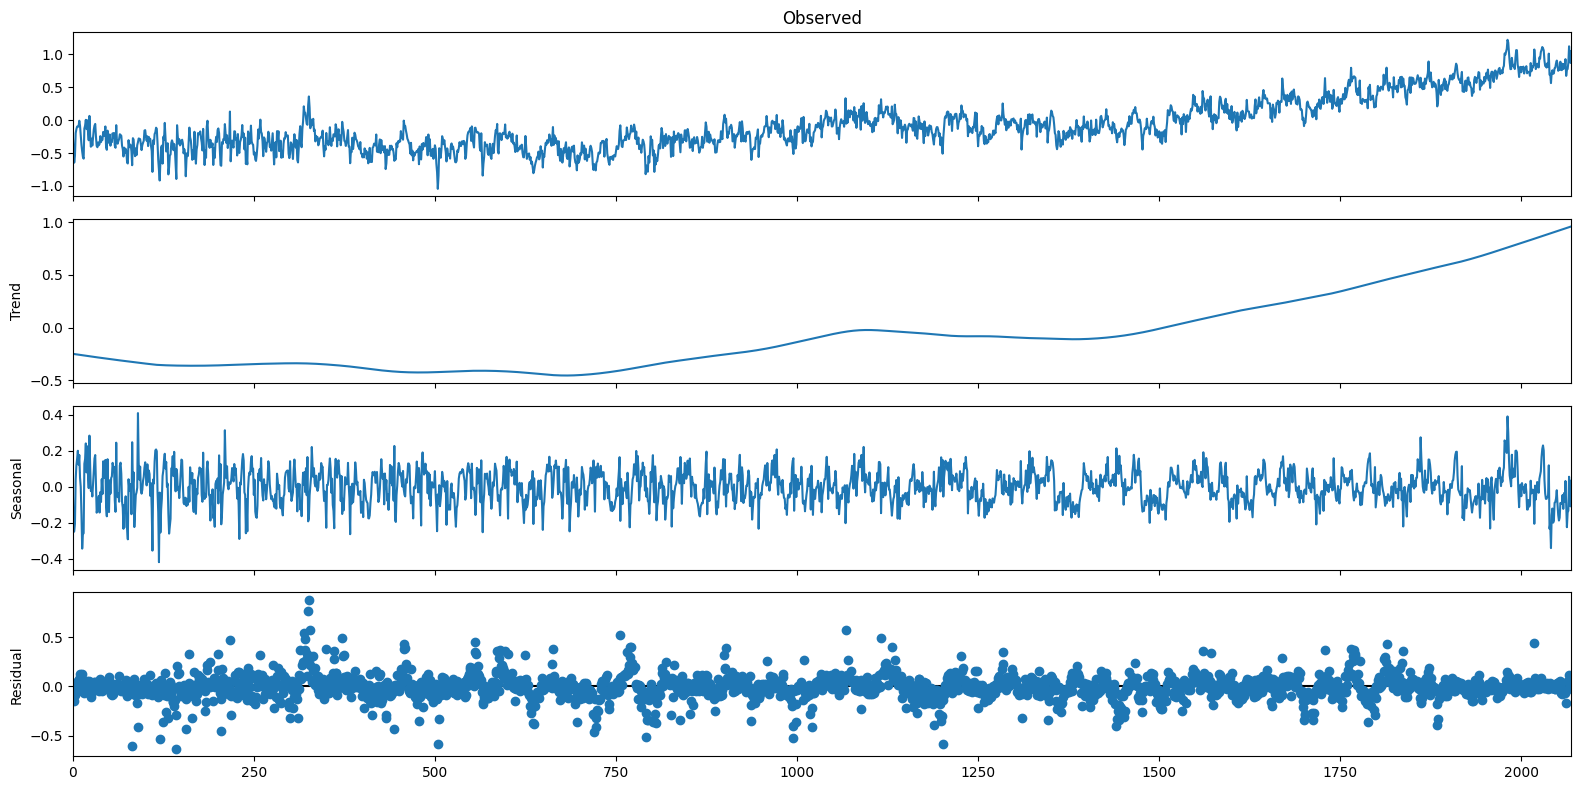

/Users/kamal/.local/lib/python3.10/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


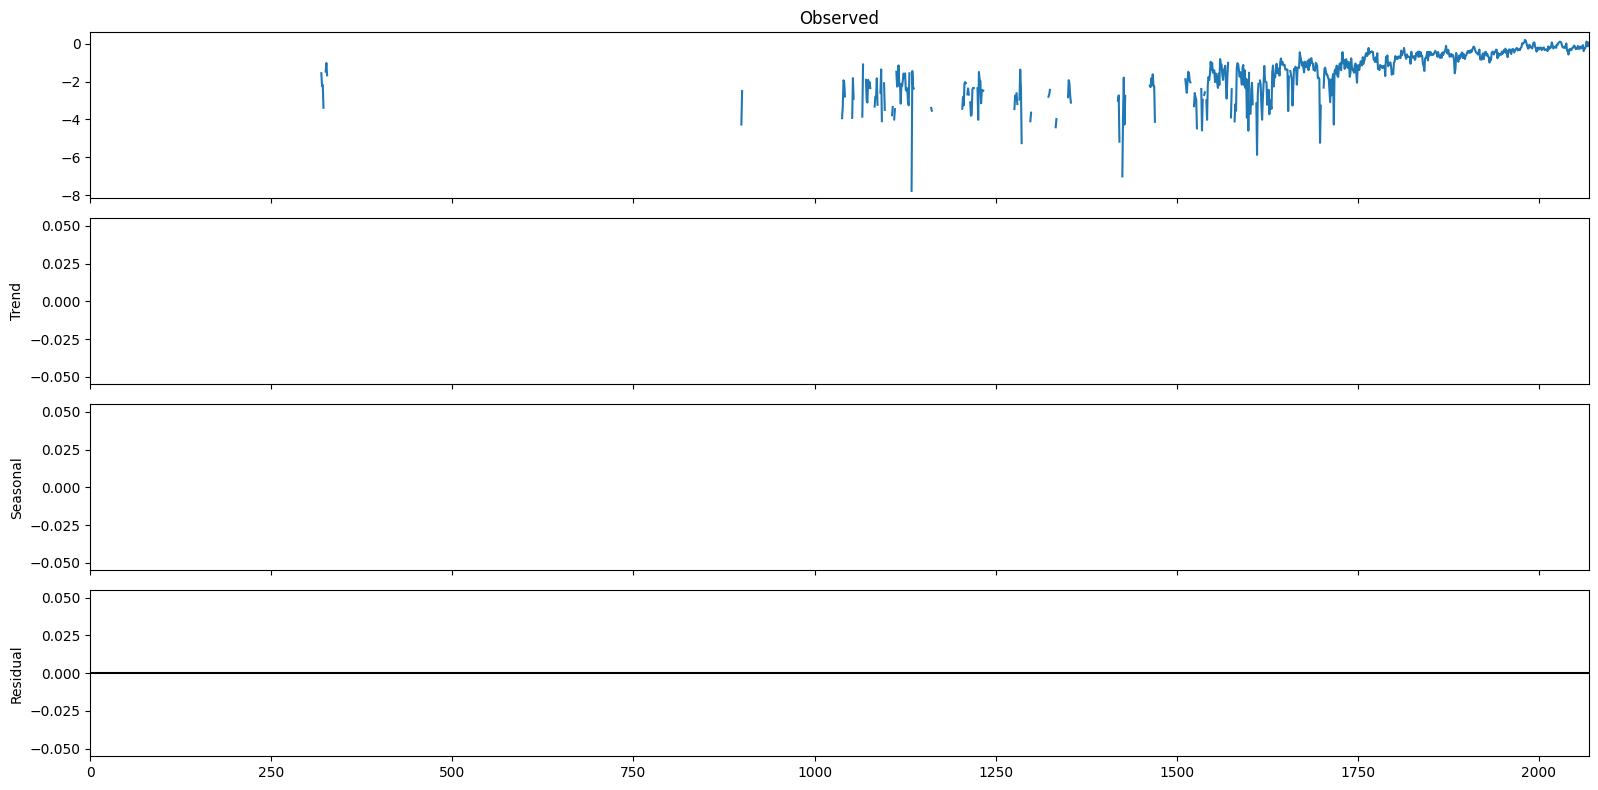

In [5]:
import statsmodels.tsa
import statsmodels.tsa.seasonal
from statsmodels.tsa.seasonal import STL

stl = STL(model_df.values.reshape(-1), period=120, robust=True)
res = stl.fit()
fig = res.plot()
plt.show()

stl = STL(np.log(model_df).values.reshape(-1), period=120, robust=True)
res = stl.fit()
fig = res.plot()
plt.show()

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#pacf_diff_img = plot_pacf(((np.log(model_df).temp_c_log.diff(12).values[12:])))
#plt.title("Partial Log-Diff Autocorrelation")
#plt.show()

AttributeError: 'DataFrame' object has no attribute 'temp_c_log'

In [7]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

In [8]:
model_sarima = pm.auto_arima(model_df['anomaly_c'], start_p=1, start_q=1,test='adf',max_p=12, max_q=12,m=12,
                            start_P=0, seasonal=True, d=None, D=1, trace=False, error_action='ignore',
                            supress_warnings=True,stepwise=True)

print(model_sarima.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                 2070
Model:             SARIMAX(1, 0, 5)x(0, 1, [1], 12)   Log Likelihood                1497.282
Date:                              Tue, 22 Aug 2023   AIC                          -2976.563
Time:                                      14:59:06   BIC                          -2925.898
Sample:                                  01-01-1851   HQIC                         -2957.987
                                       - 06-01-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0012      0.000      3.729      0.000       0.001       0.002
ar.L1          0.84

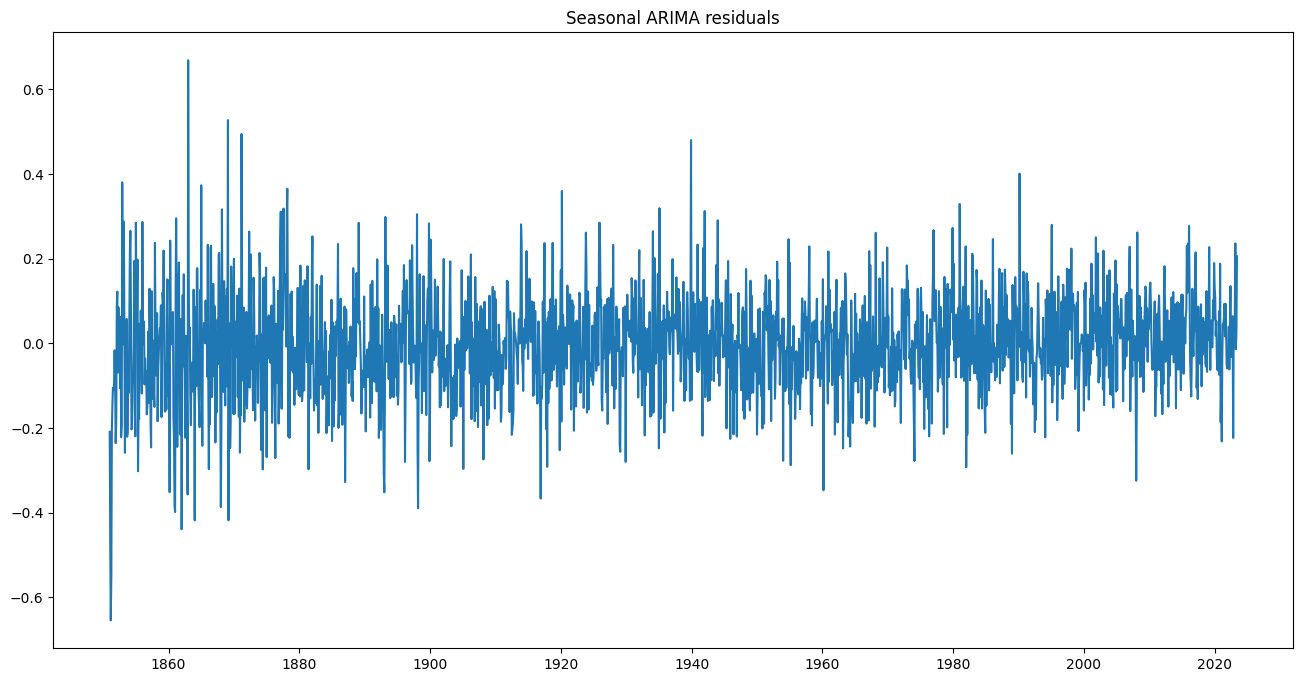

In [9]:
residuals = model_sarima.resid()
plt.plot(residuals)
plt.title("Seasonal ARIMA residuals")
plt.show()

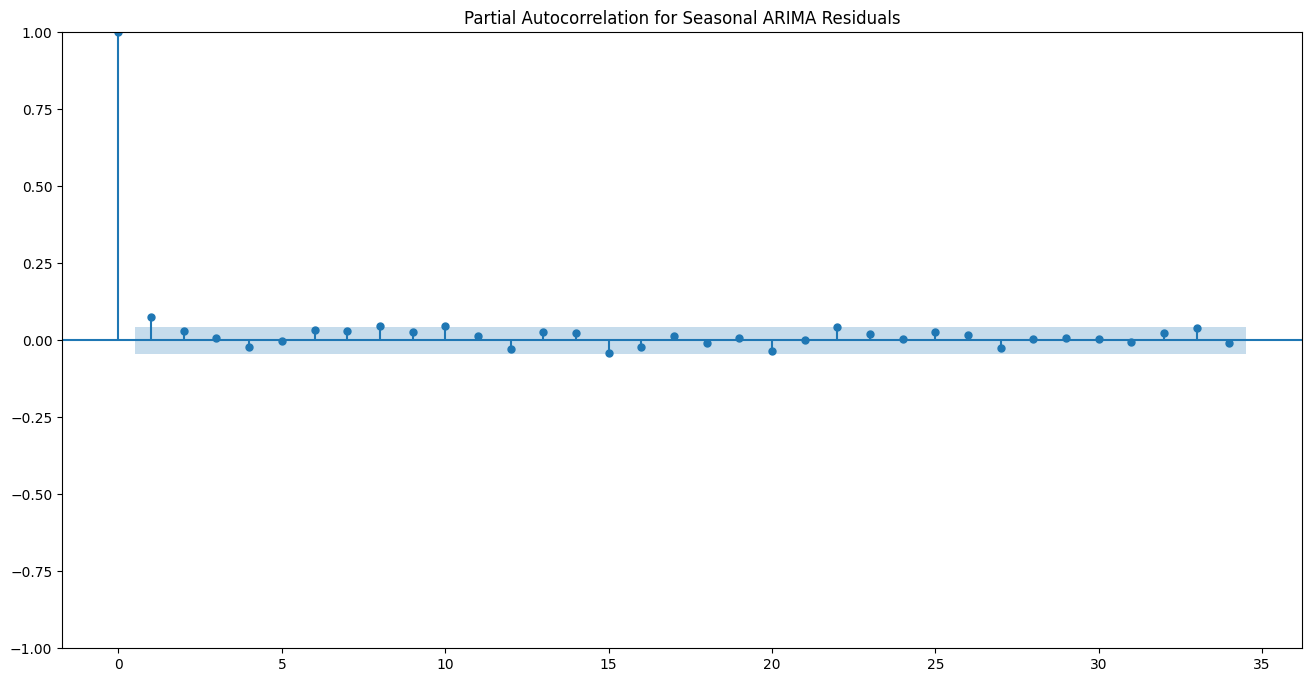

In [10]:
pacf_img = plot_pacf(residuals)
plt.title('Partial Autocorrelation for Seasonal ARIMA Residuals')
plt.show()

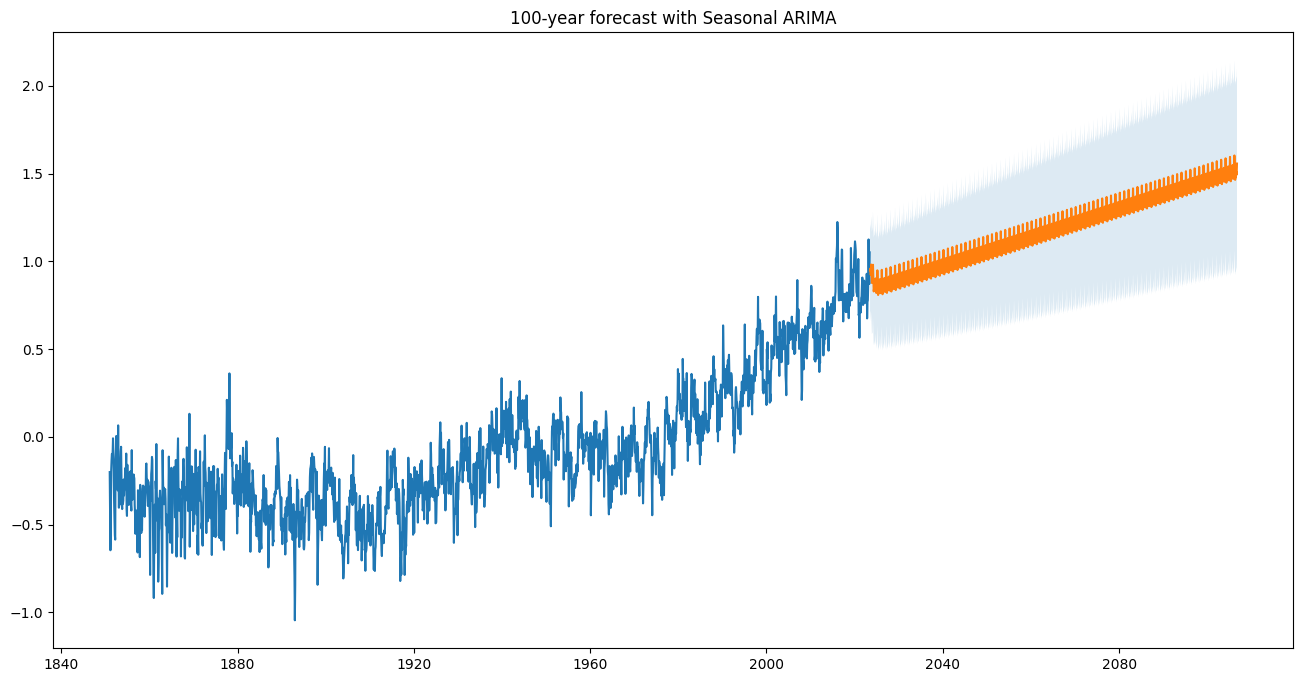

In [11]:
n_periods = 1000
fitted, confint = model_sarima.predict(n_periods, return_conf_int=True)
index_of_fc = pd.date_range(model_df.index[-1], periods = n_periods + 1, freq='MS')[1:]

fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

plt.plot(model_df)
plt.plot(fitted_series)
plt.fill_between(lower_series.index,
                 lower_series,
                 upper_series,
                 alpha=.15)

plt.title("100-year forecast with Seasonal ARIMA")
plt.show()